# Use the Model in the Real World

- Use data of GF satallite
- Test if out trained model (trained on massachusetts-roads-dataset) can do the task

In [1]:
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
import torch
import numpy as np

from models import DLinkNet34, LinkNet34, FarSegNet

In [79]:
FIG_SAVE_PATH = 'predict_result/mid_report/'

In [67]:
def plt_improve(p):
    p.xticks([])
    p.yticks([])

In [2]:
img_path = '/home/renyan/ossdata/gf-yunnan/IMG_0035.JPG'

In [3]:
img = cv2.imread(img_path)
img_part = img[0:1500,0:1500] * 4

In [4]:
transform = transforms.Compose([transforms.Resize([256, 256], 0), transforms.ToTensor(),])
img_part = transform(Image.fromarray(img))

In [5]:
img_part.shape

torch.Size([3, 256, 256])

In [69]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = LinkNet34.LinkNet34().to(device)
net.load_state_dict(torch.load('checkpoints/v2_linknet34_re_epoch20.pth'))

<All keys matched successfully>

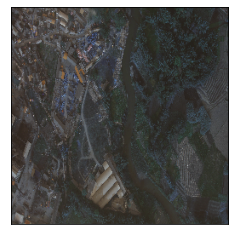

In [80]:
plt.imshow(img_part.permute(1, 2, 0))
plt_improve(plt)
plt.savefig(FIG_SAVE_PATH + 'img_gf_1.png', bbox_inches='tight')

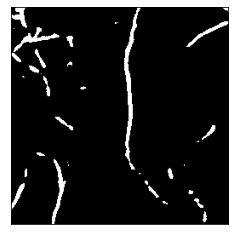

In [71]:
pred = net(img_part.unsqueeze(dim=0).to(device))
pred = (torch.sigmoid(pred).squeeze(0) > 0.51).type(torch.float32)
pred1 = torch.cat([pred]*3).permute(1, 2, 0)
plt.imshow(pred1.cpu())
plt_improve(plt)

In [72]:
net = DLinkNet34.DLinkNet34().to(device)
net.load_state_dict(torch.load('checkpoints/v2_dlinknet34_re_epoch20.pth'))

<All keys matched successfully>

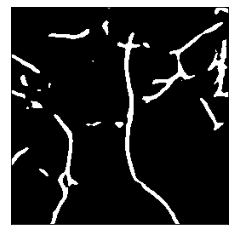

In [74]:
pred = net(img_part.unsqueeze(dim=0).to(device))
pred = (torch.sigmoid(pred).squeeze(0) > 0.51).type(torch.float32)
pred2 = torch.cat([pred]*3).permute(1, 2, 0)
plt.imshow(pred2.cpu())
plt_improve(plt)

## FarSeg

In [75]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = FarSegNet.FarSegNet().to(device)
net.eval()
net.load_state_dict(torch.load('checkpoints/' + 'v2_farseg_epoch100.pth'))

<All keys matched successfully>

In [21]:
img_part.unsqueeze(dim=0).to(device).shape

torch.Size([1, 3, 256, 256])

In [22]:
probs, preds = net(img_part.unsqueeze(dim=0).to(device))

In [52]:
pred = (probs > 0.08).float()
pred.shape

torch.Size([1, 1, 256, 256])

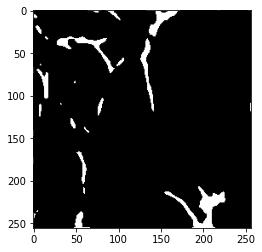

In [55]:
plt.imshow(torch.cat([pred.squeeze().unsqueeze(dim=0)]*3).permute(1, 2, 0).cpu().detach().numpy())

In [56]:
tmp = torch.cat([probs.squeeze().unsqueeze(dim=0)]*3).permute(1, 2, 0)

In [57]:
tmp.shape

torch.Size([256, 256, 3])

In [76]:
# plt.hist(probs.flatten().detach().cpu().numpy())

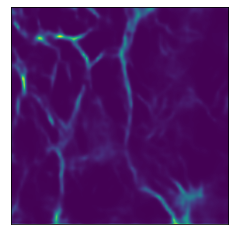

In [81]:
plt.imshow(probs.squeeze().cpu().detach().numpy()*5)
plt_improve(plt)
plt.savefig(FIG_SAVE_PATH + 'pred_gf_1_fd.png', bbox_inches='tight')

In [18]:
# pred1 = pred1.cpu().numpy()
kernel = np.ones((3,3), np.uint8)
erorsion_img = cv2.erode(pred1, kernel, iterations=1)
plt.imshow(erorsion_img)

TypeError: Expected Ptr<cv::UMat> for argument 'src'